# Simulations

In this notebook, we perform ten albedo management and afforestation simulations with pre-trained machine learning models. We compute OLS mappings of median income to simulated UHI to compare the coefficient before and after the simulation. Further, we calculate the gap between low and high income groups at the urban level across each scenario.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearnex import patch_sklearn
patch_sklearn()

import os
os.environ["SKLEARNEX_VERBOSE"] = "INFO"

from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from xgboost import XGBRegressor
import joblib
from statsmodels.stats.weightstats import DescrStatsW

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Import and Processing + Model Import

In [2]:
data = pd.read_csv('data/data.csv', low_memory=False)
urban_df = data[['Urban_name', 'Climate Zone', 'Coastal?']].drop_duplicates().copy()

data['Coastal?'] = data['Coastal?'].fillna(False).astype(int)

mapping_dict = {'Arid': 0, 'Snow': 1, 'Temperate': 2, 'Tropical': 3}
data['Climate Zone'] = data['Climate Zone'].map(mapping_dict)

In [3]:
model_at_d = joblib.load('models/full/AT_day_xgb_estimator.joblib')
model_at_n = joblib.load('models/full/AT_night_xgb_estimator.joblib')
model_lst_d = joblib.load('models/full/LST_day_xgb_estimator.joblib')
model_lst_n = joblib.load('models/full/LST_night_xgb_estimator.joblib')

In [4]:
features = ['$\\Delta$Built Fraction', '$\\Delta$Grass Fraction', '$\\Delta$Tree Fraction', 
            '$\\Delta$Built Albedo', '$\\Delta$Grass Albedo', '$\\Delta$Tree Albedo', 
            '$\\Delta$Elevation', 'Coastal?', 'Climate Zone']
labels   = ['$\\Delta$AT Day', '$\\Delta$AT Night', '$\\Delta$LST Day', '$\\Delta$LST Night']

## Simulation Helper Functions

In [5]:
def get_sim_results(X_test, simname): 
    y_pred_at_d = model_at_d.predict(X_test[features])
    y_pred_at_n = model_at_n.predict(X_test[features])
    y_pred_lst_d = model_lst_d.predict(X_test[features])
    y_pred_lst_n = model_lst_n.predict(X_test[features])
    X_test['y_pred_at_d'] = y_pred_at_d
    X_test['y_pred_at_n'] = y_pred_at_n
    X_test['y_pred_lst_d'] = y_pred_lst_d
    X_test['y_pred_lst_n'] = y_pred_lst_n
    return X_test

In [6]:
def apply_regression(group, simname):
    preds = ['y_pred_at_d', 'y_pred_at_n', 'y_pred_lst_d', 'y_pred_lst_n']
    
    series_dict = {}
    for i in range(len(preds)):
        groupXy = group[['Median Income (K)', preds[i]]].dropna().copy()
        X = groupXy['Median Income (K)']
        y = groupXy[preds[i]]
        X = sm.add_constant(X)
        model   = sm.OLS(y, np.asarray(X))
        results = model.fit()
        series_dict[simname + ' ' + labels[i] + ' Slope'] = results.params['x1']
        series_dict[simname + ' ' + labels[i] + ' pval']  = results.pvalues['x1']
        series_dict[simname + ' ' + labels[i] + ' SE']    = results.bse['x1']
    
    return pd.Series(series_dict)

In [7]:
def get_ols_results(sim_results, simname):
    ols_result = sim_results.groupby('Urban_name').apply(lambda group: apply_regression(group, simname))
    ols_result.reset_index(inplace=True)
    return ols_result

In [8]:
def apply_quantile(df, simname):
    def weighted_average(group, x):
        return np.average(group[x], weights=group['Area']) 
    def weighted_std(group, x):
        return DescrStatsW(group[x], weights=group['Area']).std
    
    targets = ['y_pred_at_d', 'y_pred_at_n', 'y_pred_lst_d', 'y_pred_lst_n']
    cols    = ['$\\Delta$AT Day', '$\\Delta$AT Night', '$\\Delta$LST Day', '$\\Delta$LST Night']

    med25 = 'Median Income (25th percentile)'
    med75 = 'Median Income (75th percentile)'

    iqr_df = pd.DataFrame(urban_df['Urban_name'])
    for i in range(len(cols)):    
        # Calculate the overall AWM by urban area
        col_awm = simname + ' ' + cols[i] + ' AWM'
        awm = pd.DataFrame({col_awm: df[['Urban_name', targets[i], 'Area']].dropna().groupby(['Urban_name']).apply(lambda group: weighted_average(group, x=targets[i]))}).reset_index()  
        iqr_df = iqr_df.merge(awm, on='Urban_name')
        # Filter data points at or below Q1 and Q3, and then calculate the median predicted UHI by urban area
        col25 = simname + ' ' + cols[i] + ' (25th %tile)'
        col75 = simname + ' ' + cols[i] + ' (75th %tile)'
        m25 = pd.DataFrame({col25: df[df[med25 + '?'] == True][['Urban_name', targets[i], 'Area']].dropna().groupby(['Urban_name']).apply(lambda group: weighted_average(group, x=targets[i])), 
                            col25 + ' Std': df[df[med25 + '?'] == True][['Urban_name', targets[i], 'Area']].dropna().groupby(['Urban_name']).apply(lambda group: weighted_std(group, x=targets[i]))}).reset_index()  
        m75 = pd.DataFrame({col75: df[df[med75 + '?'] == True][['Urban_name', targets[i], 'Area']].dropna().groupby(['Urban_name']).apply(lambda group: weighted_average(group, x=targets[i])), 
                            col75 + ' Std': df[df[med75 + '?'] == True][['Urban_name', targets[i], 'Area']].dropna().groupby(['Urban_name']).apply(lambda group: weighted_std(group, x=targets[i]))}).reset_index()
        # Update the results
        iqr_df = iqr_df.merge(m25, on='Urban_name')
        iqr_df = iqr_df.merge(m75, on='Urban_name')
        iqr_df[simname + ' ' + cols[i] + ' Gap']  = iqr_df[col75] - iqr_df[col25]
    return iqr_df

In [9]:
def run_simulation(albedo, afforest, afforest_pct, lowincomeonly, simname, filename):
    X = data.copy().dropna(subset=features+labels)
    
    if albedo == True:
        if lowincomeonly == True:
            X['$\\Delta$Built Albedo'] = np.where(X['Median Income (25th percentile)?'] == True, (0.8 - X['Albedo_Built_rur']), X['$\\Delta$Built Albedo'])
        else:
            X.loc[:, '$\\Delta$Built Albedo'] = 0.8 - X['Albedo_Built_rur']
    if afforest == True:  
        if lowincomeonly == True:
            X['$\\Delta$Tree Fraction']  = np.where(X['Median Income (25th percentile)?'] == True, (X['ESATreeFraction'] + (afforest_pct/100 * X['ESAGrassFraction'])) - X['ESATreeFractionRural'], X['$\\Delta$Tree Fraction'])
            X['$\\Delta$Grass Fraction'] = np.where(X['Median Income (25th percentile)?'] == True, (X['ESAGrassFraction'] - (afforest_pct/100 * X['ESAGrassFraction'])) - X['ESAGrassFractionRural'], X['$\\Delta$Grass Fraction'])
            X['$\\Delta$Grass Albedo']   = np.where(X['Median Income (25th percentile)?'] == True, (X['Albedo_Grass'] * X['$\\Delta$Tree Fraction'] + X['Albedo_Tree'] * X['$\\Delta$Tree Fraction']) - X['Albedo_Grass_rur'], X['$\\Delta$Grass Albedo'])

        else: 
            X['$\\Delta$Tree Fraction']  = (X['ESATreeFraction'] + (afforest_pct/100 * X['ESAGrassFraction'])) - X['ESATreeFractionRural']
            X['$\\Delta$Grass Fraction'] = (X['ESAGrassFraction'] - (afforest_pct/100 * X['ESAGrassFraction'])) - X['ESAGrassFractionRural']
            X['$\\Delta$Grass Albedo']   = (X['Albedo_Grass'] * X['$\\Delta$Tree Fraction'] + X['Albedo_Tree'] * X['$\\Delta$Tree Fraction']) - X['Albedo_Grass_rur']
    
    sim_results = get_sim_results(X, simname)
    sim_results.to_csv('tables/sim_output_full/{}.csv'.format(filename), index=False)
    iqr_result = apply_quantile(sim_results, simname)
    ols_result = get_ols_results(sim_results, simname)
    return iqr_result, ols_result, sim_results

- Save label results in separate files for comparison
- Include quartile results and coefficients in same file

In [10]:
def run_all():
    # Simulations
    simnames  = ['Baseline'] + ['Albedo Management', 'Targeted Albedo Management'] \
              + ['{}% Afforestation'.format(x) for x in list(range(10,100+10,10))] \
              + ['Targeted {}% Afforestation'.format(x) for x in list(range(10,100+10,10))] \
              + ['Albedo Management/{}% Afforestation'.format(x) for x in list(range(10,100+10,10))] \
              + ['Targeted Albedo Management/{}% Afforestation'.format(x) for x in list(range(10,100+10,10))]
    filenames = ['baseline'] + ['albedo', 'albedo_targeted'] \
              + ['afforest{}'.format(x) for x in list(range(10,100+10,10))] \
              + ['afforest{}_targeted'.format(x) for x in list(range(10,100+10,10))] \
              + ['albedo_afforest{}'.format(x) for x in list(range(10,100+10,10))] \
              + ['albedo_afforest{}_targeted'.format(x) for x in list(range(10,100+10,10))]
    albedo_list = [False] + [True, True] + ([False] * 20) + ([True] * 20)
    afforest_list = [False] + [False, False] + ([True] * 40)
    afforest_pct_list = [0] + [0,0] + list(range(10,100+10,10)) * 4
    lowincomeonly_list = [False] + [False, True] + ([False]*10) + ([True]*10) + ([False]*10) + ([True]*10)
    sim_cond = [ (a, b, c, d) for a, b, c, d in zip(albedo_list, afforest_list, afforest_pct_list, lowincomeonly_list)]
    
    targets = ['y_pred_at_d', 'y_pred_at_n', 'y_pred_lst_d', 'y_pred_lst_n']
    all_sim_output = pd.DataFrame(data[['Census_geoid', 'Urban_name']])
    result = urban_df.copy().reset_index().drop(columns='index')
    for i in range(len(sim_cond)):
        iqr_result, ols_result, sim_results = run_simulation(albedo=sim_cond[i][0], afforest=sim_cond[i][1], 
                                                             afforest_pct=sim_cond[i][2], lowincomeonly=sim_cond[i][3], 
                                                             simname=simnames[i], filename=filenames[i])
        result = result.merge(iqr_result, on='Urban_name')
        result = result.merge(ols_result, on='Urban_name')
        
        all_sim_output = all_sim_output.merge(sim_results[['Census_geoid']+targets], on='Census_geoid')
        all_sim_output.rename(columns=dict(zip(targets, [simnames[i] + ' ' + label for label in labels ])), inplace=True)
    result.to_csv('tables/sim_results/sim_results.csv', index=False)
    all_sim_output.to_csv('tables/simulations.csv', index=False)
    return result

In [11]:
final_result = run_all()

In [12]:
len(final_result)

493

In [13]:
final_result.head()

Urban_name Climate Zone Coastal?  Baseline $\Delta$AT Day AWM  \
0      Abilene, TX    Temperate    False                    -0.013062   
1       Albany, OR    Temperate    False                     0.024125   
2  Albuquerque, NM         Arid    False                     0.146844   
3   Alexandria, LA    Temperate    False                    -0.011185   
4    Alton, IL--MO    Temperate    False                     0.041421   

   Baseline $\Delta$AT Day (25th %tile)  \
0                              0.426707   
1                              0.473501   
2                              2.391964   
3                              0.141920   
4                              0.406859   

   Baseline $\Delta$AT Day (25th %tile) Std  \
0                                  0.114001   
1                                  0.284908   
2                                  0.456739   
3                                  0.141223   
4                                  0.101491   

   Baseline $\Delta$AT Day (75th %tile)  \
0                             -0.084702   
1                              0.034839   
2                             -0.607033   
3                             -0.046097   
4                             -0.001700   

   Baseline $\Delta$AT Day (75th %tile) Std  Baseline $\Delta$AT Day Gap  \
0                                  0.192970                    -0.511409   
1                                  0.052425                    -0.438663   
2                                  2.042812                    -2.998997   
3                                  0.081814                    -0.188017   
4                                  0.067445                    -0.408559   

   Baseline $\Delta$AT Night AWM  Baseline $\Delta$AT Night (25th %tile)  \
0                       0.035357                                0.417465   
1                       0.020883                                0.907743   
2                       0.152624                                1.844873   
3                       0.007074                                0.107185   
4                       0.058170                                0.534732   

   Baseline $\Delta$AT Night (25th %tile) Std  \
0                                    0.143012   
1                                    0.062471   
2                                    0.617917   
3                                    0.156283   
4                                    0.184482   

   Baseline $\Delta$AT Night (75th %tile)  \
0                               -0.034359   
1                                0.094063   
2                                0.395542   
3                               -0.004922   
4                               -0.006221   

   Baseline $\Delta$AT Night (75th %tile) Std  Baseline $\Delta$AT Night Gap  \
0                                    0.150640                      -0.451824   
1                                    0.049316                      -0.813679   
2                                    1.051646                      -1.449331   
3                                    0.034744                      -0.112107   
4                                    0.146554                      -0.540953   

   Baseline $\Delta$LST Day AWM  Baseline $\Delta$LST Day (25th %tile)  \
0                     -0.050014                               1.219299   
1                      0.250133                               3.694146   
2                      0.165249                               3.266532   
3                      0.143191                               1.653573   
4                      0.473744                               3.477486   

   Baseline $\Delta$LST Day (25th %tile) Std  \
0                                   0.562781   
1                                   1.629748   
2                                   0.966388   
3                                   1.517227   
4                                   1.307299   

   Baseline $\Delta$LST Day (75th %tile)  \
0                            

## Graphs

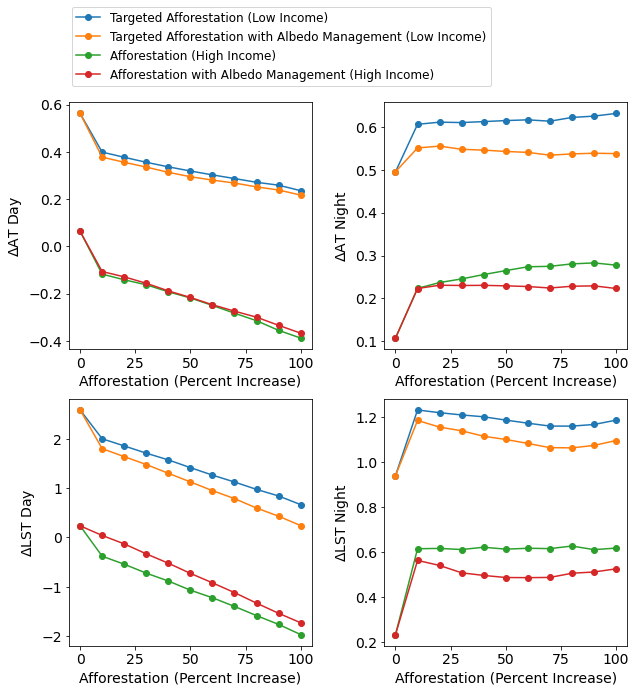

In [26]:
plt.rcParams.update({'font.size': 14}) # Set font size
nrows, cols = 2, 2
fig, axes = plt.subplots(nrows, cols, figsize=(10,10))
targets = ['$\\Delta$AT Day', '$\\Delta$AT Night', '$\\Delta$LST Day', '$\\Delta$LST Night']

for k, ax in enumerate(axes.flatten()):
    
    a_25  = ['Baseline {} (25th %tile)'.format(targets[k])] + ['{}% Afforestation {} (25th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]
    ta_25 = ['Baseline {} (25th %tile)'.format(targets[k])] + ['Targeted {}% Afforestation {} (25th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]
    a_am_25  = ['Baseline {} (25th %tile)'.format(targets[k])] + ['Albedo Management/{}% Afforestation {} (25th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]
    ta_am_25 = ['Baseline {} (25th %tile)'.format(targets[k])] + ['Targeted Albedo Management/{}% Afforestation {} (25th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]

    a_75  = ['Baseline {} (75th %tile)'.format(targets[k])] + ['{}% Afforestation {} (75th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]
    ta_75 = ['Baseline {} (75th %tile)'.format(targets[k])] + ['Targeted {}% Afforestation {} (75th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]
    a_am_75  = ['Baseline {} (75th %tile)'.format(targets[k])] + ['Albedo Management/{}% Afforestation {} (75th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]
    ta_am_75 = ['Baseline {} (75th %tile)'.format(targets[k])] + ['Targeted Albedo Management/{}% Afforestation {} (75th %tile)'.format(a, t) for a, t in zip(list(range(10,100+10,10)), [targets[k]] * 10) ]

    
    ax.plot(list(range(0,100+10,10)), [final_result[col].mean() for col in ta_25], marker='o', linestyle='-', label='Targeted Afforestation (Low Income)')
    ax.plot(list(range(0,100+10,10)), [final_result[col].mean() for col in ta_am_25], marker='o', linestyle='-', label='Targeted Afforestation with Albedo Management (Low Income)')

    ax.plot(list(range(0,100+10,10)), [final_result[col].mean() for col in a_75], marker='o', linestyle='-', label='Afforestation (High Income)')
    ax.plot(list(range(0,100+10,10)), [final_result[col].mean() for col in a_am_75], marker='o', linestyle='-', label='Afforestation with Albedo Management (High Income)')
    #ax.axhline(y=final_result['Targeted 10% Afforestation {} (75th %tile)'.format(targets[k])].mean(), color='r', linestyle='--', linewidth=2, label='Targeted Strategies (High Income)')

    ax.set_xlabel('Afforestation (Percent Increase)')
    ax.set_ylabel(targets[k])
axes[0,0].legend(bbox_to_anchor=(0.875,1.225), loc='center', fontsize=12)
plt.subplots_adjust(wspace=0.3)
plt.savefig('graphs/simulations/income_sim_increment_comparison.jpg', bbox_inches='tight', dpi=1000)
plt.savefig('graphs/simulations/income_sim_increment_comparison.pdf', bbox_inches='tight', dpi=1000)

## Descriptive Statistics

In [15]:
final_result['Baseline $\\Delta$AT Day Gap'].agg(['mean', 'std']).round(2)

mean   -0.50
std     0.94
Name: Baseline $\Delta$AT Day Gap, dtype: float64

In [16]:
final_result[['100% Afforestation $\\Delta$AT Day Gap', 
              'Albedo Management/100% Afforestation $\\Delta$AT Day Gap']].agg(['mean', 'std']).round(2)

,100% Afforestation $\Delta$AT Day Gap,Albedo Management/100% Afforestation $\Delta$AT Day Gap
mean,-0.62,-0.58
std,1.04,0.95


In [17]:
final_result[['Targeted 100% Afforestation $\\Delta$AT Day Gap', 
              'Targeted Albedo Management/100% Afforestation $\\Delta$AT Day Gap']].agg(['mean', 'std']).round(2)

,Targeted 100% Afforestation $\Delta$AT Day Gap,Targeted Albedo Management/100% Afforestation $\Delta$AT Day Gap
mean,-0.17,-0.15
std,0.93,0.91


In [18]:
final_result[['Baseline $\\Delta$AT Day (25th %tile)','100% Afforestation $\\Delta$AT Day (25th %tile)', 
              'Albedo Management/100% Afforestation $\\Delta$AT Day (25th %tile)']].agg(['mean', 'std']).round(2)

,Baseline $\Delta$AT Day (25th %tile),100% Afforestation $\Delta$AT Day (25th %tile),Albedo Management/100% Afforestation $\Delta$AT Day (25th %tile)
mean,0.56,0.24,0.22
std,0.94,0.93,0.92


In [19]:
final_result.groupby('Climate Zone')['Baseline $\\Delta$AT Day AWM'].agg(['mean', 'std']).round(2)

,mean,std
Climate Zone,,
Arid,0.08,0.11
Snow,0.07,0.13
Temperate,0.06,0.20
Tropical,0.19,0.16


In [20]:
clim_zone_at_day_gap = final_result.groupby(['Climate Zone'])[['Baseline $\\Delta$AT Day Gap',
                                        'Albedo Management $\\Delta$AT Day Gap',
                                        'Targeted Albedo Management $\\Delta$AT Day Gap',
                                        '50% Afforestation $\\Delta$AT Day Gap',
                                        '100% Afforestation $\\Delta$AT Day Gap',
                                        'Targeted 50% Afforestation $\\Delta$AT Day Gap',
                                        'Targeted 100% Afforestation $\\Delta$AT Day Gap',
                                        'Albedo Management/50% Afforestation $\\Delta$AT Day Gap', 
                                        'Albedo Management/100% Afforestation $\\Delta$AT Day Gap', 
                                        'Targeted Albedo Management/50% Afforestation $\\Delta$AT Day Gap', 
                                        'Targeted Albedo Management/100% Afforestation $\\Delta$AT Day Gap']].agg(['mean', 'std']).round(2)
clim_zone_at_day_gap.T.to_csv('tables/daytime_at_climzone.csv')
clim_zone_at_day_gap


Baseline $\Delta$AT Day Gap        \
                                    mean   std   
Climate Zone                                     
Arid                               -0.64  1.19   
Snow                               -0.64  0.92   
Temperate                          -0.44  0.90   
Tropical                            0.14  0.61   

             Albedo Management $\Delta$AT Day Gap        \
                                             mean   std   
Climate Zone                                              
Arid                                        -0.62  1.21   
Snow                                        -0.59  0.90   
Temperate                                   -0.42  0.86   
Tropical                                     0.17  0.62   

             Targeted Albedo Management $\Delta$AT Day Gap        \
                                                      mean   std   
Climate Zone                                                       
Arid                                                 -0.57  1.18   
Snow                                                 -0.58  0.92   
Temperate                                            -0.39  0.87   
Tropical                                              0.17  0.64   

             50% Afforestation $\Delta$AT Day Gap        \
                                             mean   std   
Climate Zone                                              
Arid                                        -0.76  1.28   
Snow                                        -0.72  1.02   
Temperate                                   -0.45  0.94   
Tropical                                     0.26  0.75   

             100% Afforestation $\Delta$AT Day Gap        \
                                              mean   std   
Climate Zone                                               
Arid                                         -0.78  1.27   
Snow                                         -0.80  1.09   
Temperate                                    -0.55  0.98   
Tropical                                      0.19  0.48   

             Targeted 50% Afforestation $\Delta$AT Day Gap        \
                                                      mean   std   
Climate Zone                                                       
Arid                                                 -0.34  1.21   
Snow                                                 -0.45  0.93   
Temperate                                            -0.18  0.87   
Tropical                                              0.33  0.71   

             Targeted 100% Afforestation $\Delta$AT Day Gap        \
                                                       mean   std   
Climate Zone                                                        
Arid                                                  -0.24  1.21   
Snow                                                  -0.48  0.87   
Temperate                                             -0.05  0.87   
Tropical                                               0.54  0.64   

             Albedo Management/50% Afforestation $\Delta$AT Day Gap        \
                                                               mean   std   
Climate Zone                                                                
Arid                                                      -0.73      1.23   
Snow                                                      -0.67      0.96   
Temperate                                                 -0.44      0.86   
Tropical                                                   0.18      0.70   

             Albedo Management/100% Afforestation $\Delta$AT Day Gap        \
                                                                mean   std   
Climate Zone                                                                 
Arid                                                      -0.75       1.20   
Snow                                                      -0.69       0.97   
Temperate                                    

In [21]:
cols = ['Baseline $\\Delta$AT Night Gap', 'Albedo Management $\\Delta$AT Night Gap',
        'Targeted Albedo Management $\\Delta$AT Night Gap', '50% Afforestation $\\Delta$AT Night Gap',
        '100% Afforestation $\\Delta$AT Night Gap', 'Targeted 50% Afforestation $\\Delta$AT Night Gap',
        'Targeted 100% Afforestation $\\Delta$AT Night Gap', 'Albedo Management/50% Afforestation $\\Delta$AT Night Gap', 
        'Albedo Management/100% Afforestation $\\Delta$AT Night Gap',
        'Targeted Albedo Management/50% Afforestation $\\Delta$AT Night Gap', 
        'Targeted Albedo Management/100% Afforestation $\\Delta$AT Night Gap']

clim_zone_at_night_gap = final_result.groupby(['Climate Zone'])[cols].agg(['mean', 'std']).round(2)
clim_zone_at_night_gap.T.to_csv('tables/nighttime_at_clim_zone.csv')
clim_zone_at_night_gap



Baseline $\Delta$AT Night Gap        \
                                      mean   std   
Climate Zone                                       
Arid                                 -0.54  1.06   
Snow                                 -0.57  0.59   
Temperate                            -0.30  0.53   
Tropical                              0.19  0.79   

             Albedo Management $\Delta$AT Night Gap        \
                                               mean   std   
Climate Zone                                                
Arid                                          -0.54  0.92   
Snow                                          -0.51  0.60   
Temperate                                     -0.28  0.49   
Tropical                                       0.16  0.74   

             Targeted Albedo Management $\Delta$AT Night Gap        \
                                                        mean   std   
Climate Zone                                                         
Arid                                                   -0.39  0.94   
Snow                                                   -0.45  0.57   
Temperate                                              -0.21  0.50   
Tropical                                                0.18  0.73   

             50% Afforestation $\Delta$AT Night Gap        \
                                               mean   std   
Climate Zone                                                
Arid                                          -0.43  1.02   
Snow                                          -0.49  0.56   
Temperate                                     -0.29  0.46   
Tropical                                       0.05  0.60   

             100% Afforestation $\Delta$AT Night Gap        \
                                                mean   std   
Climate Zone                                                 
Arid                                           -0.41  0.96   
Snow                                           -0.46  0.67   
Temperate                                      -0.32  0.53   
Tropical                                        0.13  0.58   

             Targeted 50% Afforestation $\Delta$AT Night Gap        \
                                                        mean   std   
Climate Zone                                                         
Arid                                                   -0.61  1.05   
Snow                                                   -0.68  0.61   
Temperate                                              -0.43  0.49   
Tropical                                               -0.00  0.72   

             Targeted 100% Afforestation $\Delta$AT Night Gap        \
                                                         mean   std   
Climate Zone                                                          
Arid                                                    -0.64  0.99   
Snow                                                    -0.72  0.63   
Temperate                                               -0.44  0.52   
Tropical                                                 0.08  0.70   

             Albedo Management/50% Afforestation $\Delta$AT Night Gap        \
                                                                 mean   std   
Climate Zone                                                                  
Arid                                                      -0.43        0.93   
Snow                                                      -0.42        0.56   
Temperate                                                 -0.26        0.43   
Tropical                                                   0.01        0.60   

             Albedo Management/100% Afforestation $\Delta$AT Night Gap        \
                                                                  mean   std   
Climate Zone                                                                   
Arid                                                      -0.36         0.90   
Sno

## Statistically Significant Gaps

In [22]:
# Code adapted from: https://365datascience.com/calculators/difference-in-means-calculator/
from scipy.stats import t
def two_sample_ttest(n1, n2, mean1, mean2, std_dev1, std_dev2):
    # Null hypothesis: The mean difference is zero
    # Alternative hypothesis: The mean difference is not zero
    null_mean = 0

    # Calculate the pooled standard deviation
    pooled_std_dev = np.sqrt(((n1-1) * std_dev1**2 + (n2-1) * std_dev2**2) / (n1 + n2 - 2))

    # Calculate the standard error of the difference
    se = pooled_std_dev * np.sqrt((1/n1) + (1/n2))

    # Calculate the t-statistic
    t_statistic = (mean1 - mean2 - null_mean) / se

    # Degrees of freedom
    df = n1 + n2 - 2

    # Calculate the p-value
    p_value = 2 * (1 - t.cdf(abs(t_statistic), df=df))

    # Return the p-value
    return p_value

### Overall Statistically Significant Gaps

In [23]:
sims = ['Baseline', 'Albedo Management', 'Targeted Albedo Management', 
        '50% Afforestation', '100% Afforestation', 'Targeted 50% Afforestation', 'Targeted 100% Afforestation', 
        'Albedo Management/50% Afforestation', 'Albedo Management/100% Afforestation', 
        'Targeted Albedo Management/50% Afforestation', 'Targeted Albedo Management/100% Afforestation']
cols    = ['$\\Delta$AT Day', '$\\Delta$AT Night', '$\\Delta$LST Day', '$\\Delta$LST Night']
gap_sig = []
sim_col = []
for sim in sims:
    for col in cols:
        sim_col.append(sim + ' ' + col)

for sim in sim_col:
    pval = two_sample_ttest(n1=data[data['Median Income (75th percentile)?']==True]['Median Income (75th percentile)?'].value_counts()[0],
                            n2=data[data['Median Income (25th percentile)?']==True]['Median Income (25th percentile)?'].value_counts()[0],
                            mean1=final_result[sim + ' (75th %tile)'].mean(),
                            mean2=final_result[sim + ' (25th %tile)'].mean(),
                            std_dev1=final_result[sim + ' (75th %tile) Std'].mean(), 
                            std_dev2=final_result[sim + ' (25th %tile) Std'].mean())
    gap_sig.append(pval)
print(len(sim_col))

sim_sig = pd.DataFrame({'Simulation': sim_col, 'pval':gap_sig})
sim_sig

44


,Simulation,pval
0,Baseline $\Delta$AT Day,0.000000
1,Baseline $\Delta$AT Night,0.000000
2,Baseline $\Delta$LST Day,0.000000
3,Baseline $\Delta$LST Night,0.000000
4,Albedo Management $\Delta$AT Day,0.000000
5,Albedo Management $\Delta$AT Night,0.000000
6,Albedo Management $\Delta$LST Day,0.000000
7,Albedo Management $\Delta$LST Night,0.000000
8,Targeted Albedo Management $\Delta$AT Day,0.000000
9,Targeted Albedo Management $\Delta$AT Night,0.000000


### Statistically Significant Gaps by Climate Zone

In [24]:
sims = ['Baseline', 'Albedo Management', 'Targeted Albedo Management', 
        '50% Afforestation', '100% Afforestation', 'Targeted 50% Afforestation', 'Targeted 100% Afforestation', 
        'Albedo Management/50% Afforestation', 'Albedo Management/100% Afforestation', 
        'Targeted Albedo Management/50% Afforestation', 'Targeted Albedo Management/100% Afforestation']
cols    = ['$\\Delta$AT Day', '$\\Delta$AT Night']
gap_sig_arid = []
gap_sig_snow = []
gap_sig_temp = []
gap_sig_trop = []
sim_col = []
for sim in sims:
    for col in cols:
        sim_col.append(sim + ' ' + col)

#idx+=0
for sim in sim_col:
    pval = two_sample_ttest(n1=data[(data['Median Income (75th percentile)?']==True) & (data['Climate Zone'] == 0)]['Median Income (75th percentile)?'].value_counts()[0],
                            n2=data[(data['Median Income (25th percentile)?']==True) & (data['Climate Zone'] == 0)]['Median Income (25th percentile)?'].value_counts()[0],
                            mean1=final_result[final_result['Climate Zone']=='Arid'][sim + ' (75th %tile)'].mean(),
                            mean2=final_result[final_result['Climate Zone']=='Arid'][sim + ' (25th %tile)'].mean(),
                            std_dev1=final_result[final_result['Climate Zone']=='Arid'][sim + ' (75th %tile) Std'].mean(), 
                            std_dev2=final_result[final_result['Climate Zone']=='Arid'][sim + ' (25th %tile) Std'].mean())
    gap_sig_arid.append(pval)
    
    pval = two_sample_ttest(n1=data[(data['Median Income (75th percentile)?']==True) & (data['Climate Zone'] == 1)]['Median Income (75th percentile)?'].value_counts()[0],
                            n2=data[(data['Median Income (25th percentile)?']==True) & (data['Climate Zone'] == 1)]['Median Income (25th percentile)?'].value_counts()[0],
                            mean1=final_result[final_result['Climate Zone']=='Snow'][sim + ' (75th %tile)'].mean(),
                            mean2=final_result[final_result['Climate Zone']=='Snow'][sim + ' (25th %tile)'].mean(),
                            std_dev1=final_result[final_result['Climate Zone']=='Snow'][sim + ' (75th %tile) Std'].mean(), 
                            std_dev2=final_result[final_result['Climate Zone']=='Snow'][sim + ' (25th %tile) Std'].mean())
    gap_sig_snow.append(pval)
    
    pval = two_sample_ttest(n1=data[(data['Median Income (75th percentile)?']==True) & (data['Climate Zone'] == 2)]['Median Income (75th percentile)?'].value_counts()[0],
                            n2=data[(data['Median Income (25th percentile)?']==True) & (data['Climate Zone'] == 2)]['Median Income (25th percentile)?'].value_counts()[0],
                            mean1=final_result[final_result['Climate Zone']=='Temperate'][sim + ' (75th %tile)'].mean(),
                            mean2=final_result[final_result['Climate Zone']=='Temperate'][sim + ' (25th %tile)'].mean(),
                            std_dev1=final_result[final_result['Climate Zone']=='Temperate'][sim + ' (75th %tile) Std'].mean(), 
                            std_dev2=final_result[final_result['Climate Zone']=='Temperate'][sim + ' (25th %tile) Std'].mean())
    gap_sig_temp.append(pval)
    
    pval = two_sample_ttest(n1=data[(data['Median Income (75th percentile)?']==True) & (data['Climate Zone'] == 3)]['Median Income (75th percentile)?'].value_counts()[0],
                            n2=data[(data['Median Income (25th percentile)?']==True) & (data['Climate Zone'] == 3)]['Median Income (25th percentile)?'].value_counts()[0],
                            mean1=final_result[final_result['Climate Zone']=='Tropical'][sim + ' (75th %tile)'].mean(),
                            mean2=final_result[final_result['Climate Zone']=='Tropical'][sim + ' (25th %tile)'].mean(),
                            std_dev1=final_result[final_result['Climate Zone']=='Tropical'][sim + ' (75th %tile) Std'].mean(), 
                            std_dev2=final_result[final_result['Climate Zone']=='Tropical'][sim + ' (25th %tile) Std'].mean())
    gap_sig_trop.append(pval)
print(len(sim_col))

sim_sig_clim = pd.DataFrame({'Simulation': sim_col, 
                             'Arid pval':gap_sig_arid, 
                             'Snow pval':gap_sig_snow, 
                             'Temperate pval':gap_sig_temp, 
                             'Tropical pval':gap_sig_trop})
sim_sig_clim


22


,Simulation,Arid pval,Snow pval,Temperate pval,Tropical pval
0,Baseline $\Delta$AT Day,0.0,0.0,0.0,1.666494e-09
1,Baseline $\Delta$AT Night,0.0,0.0,0.0,8.576777e-10
2,Albedo Management $\Delta$AT Day,0.0,0.0,0.0,1.044942e-12
3,Albedo Management $\Delta$AT Night,0.0,0.0,0.0,9.789013e-08
4,Targeted Albedo Management $\Delta$AT Day,0.0,0.0,0.0,7.096546e-13
5,Targeted Albedo Management $\Delta$AT Night,0.0,0.0,0.0,4.047078e-10
6,50% Afforestation $\Delta$AT Day,0.0,0.0,0.0,4.440892e-16
7,50% Afforestation $\Delta$AT Night,0.0,0.0,0.0,1.036469e-01
8,100% Afforestation $\Delta$AT Day,0.0,0.0,0.0,2.250689e-11
9,100% Afforestation $\Delta$AT Night,0.0,0.0,0.0,2.014473e-07


In [25]:
pd.DataFrame({
    'Simulation': sim_col,
    'Arid pval': np.where(sim_sig_clim['Arid pval'] < 0.05, True, np.nan),
    'Snow pval': np.where(sim_sig_clim['Snow pval'] < 0.05, True, np.nan),
    'Temperate pval': np.where(sim_sig_clim['Temperate pval'] < 0.05, True, np.nan),
    'Tropical pval': np.where(sim_sig_clim['Tropical pval'] < 0.05, True, np.nan)
})


,Simulation,Arid pval,Snow pval,Temperate pval,Tropical pval
0,Baseline $\Delta$AT Day,1.0,1.0,1.0,1.0
1,Baseline $\Delta$AT Night,1.0,1.0,1.0,1.0
2,Albedo Management $\Delta$AT Day,1.0,1.0,1.0,1.0
3,Albedo Management $\Delta$AT Night,1.0,1.0,1.0,1.0
4,Targeted Albedo Management $\Delta$AT Day,1.0,1.0,1.0,1.0
5,Targeted Albedo Management $\Delta$AT Night,1.0,1.0,1.0,1.0
6,50% Afforestation $\Delta$AT Day,1.0,1.0,1.0,1.0
7,50% Afforestation $\Delta$AT Night,1.0,1.0,1.0,NaN
8,100% Afforestation $\Delta$AT Day,1.0,1.0,1.0,1.0
9,100% Afforestation $\Delta$AT Night,1.0,1.0,1.0,1.0


In [27]:
list(data.columns)

['system:index',
 'AT_urb_day_CT_act_summer',
 'AT_urb_day_all_summer',
 'AT_urb_night_CT_act_summer',
 'AT_urb_night_all_summer',
 'Albedo',
 'Albedo_Built',
 'Albedo_Built_all',
 'Albedo_Grass',
 'Albedo_Grass_all',
 'Albedo_Tree',
 'Albedo_Tree_all',
 'Albedo_all',
 'Area',
 'Census_geoid',
 'DEM_urb_CT',
 'DEM_urb_CT_act',
 'DEM_urb_all',
 'ESABuilt',
 'ESABuilt_all',
 'ESAGrass',
 'ESAGrass_all',
 'ESATree',
 'ESATree_all',
 'LST_urb_day_CT_act_summer',
 'LST_urb_day_all_summer',
 'LST_urb_night_CT_act_summer',
 'LST_urb_night_all_summer',
 'Urban_geoid',
 'Urban_name',
 'Urban_name_extended',
 '.geo',
 'Climate Zone',
 'Coastal?',
 'AT_rur_day_summer',
 'AT_rur_night_summer',
 'LST_rur_day_summer',
 'LST_rur_night_summer',
 'DEM_rur',
 'Albedo_Built_rur',
 'Albedo_Grass_rur',
 'Albedo_Tree_rur',
 'Albedo_rur',
 'Area_rur',
 'ESABuilt_rur',
 'ESAGrass_rur',
 'ESATree_rur',
 '$\\Delta$AT Day',
 '$\\Delta$AT Night',
 '$\\Delta$LST Day',
 '$\\Delta$LST Night',
 'ESABuiltFraction',
 '